In [1]:
import sys
sys.path.append('D:\\projects\\job-vacancies\\jvwspace')

import data_access.da as da
import mtch.ma as ma
from mtch.match_alg import MalgType
import support.bokeh_helper as bh
import support.jncommon as jncommon
from support.common import *
import support.general_helper as gh
import support.path_helper as ph

%load_ext autoreload
%autoreload 2


2018-06-07 13:08:35,892     DEBUG                                  jvp >>> Logger jvp initialized


In [2]:
##--> imports
import numpy as np
import pandas as pd
from os import chdir, getcwd

##--> plotting imports
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.widgets import Slider
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

##--> area under a curve
from scipy.integrate import simps
from numpy import trapz

##--> standardization
from sklearn import preprocessing
scale = preprocessing.scale #standardization
normalize = preprocessing.normalize #normalization

##-->
from datetime import datetime

import re

from sklearn.linear_model import LinearRegression
from sklearn.metrics import *

%matplotlib inline

import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

C:\Python36\envs\jvp\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
##--> loading survey data
dft = pd.read_csv(ph.from_data_root('others/sarimax-survey.csv'))#.dropna(axis=1)

infos = []
for i in dft['dates']:
    datetimeobject = datetime.strptime(i,'%d/%m/%Y')
    newformat = datetimeobject.strftime('%Y-%m-%d')
    infos.append(newformat)
    
dft['dates']=infos
dft['dates']= dft['dates'].apply(pd.to_datetime)
dft = dft.loc[dft['dates']>= '2012-03-01'].drop('portal', axis=1)
dft = dft.rename(index = str, columns= {'count':'count_sv'})
dft= dft.set_index('dates')
dft.head()

,count_sv
dates,
2012-03-01,455284
2012-04-01,484946
2012-05-01,477064
2012-06-01,485211
2012-07-01,510895


In [4]:
##--> loading the data:
df = pd.read_csv(ph.from_data_root('bg_data.csv'))
df['date'] = '20' + df['date']
df = df.rename(index = str, columns= {'count':'count_bg'})
df = df.loc[df['date']>= '2012-02-01']
df['date'] = df['date'].apply(pd.to_datetime)
df = df.set_index('date')
df.head()

,Unnamed: 0,count_bg
date,,
2012-02-01,1215,402579
2012-02-02,1216,424932
2012-02-03,1217,432816
2012-02-04,1218,440374
2012-02-05,1219,463247


,date,count_bg,count_sv
0,2012-03-01,487462,455284.0
1,2012-04-01,574356,484946.0
2,2012-05-01,584676,477064.0
3,2012-06-01,623120,485211.0
4,2012-07-01,613888,510895.0


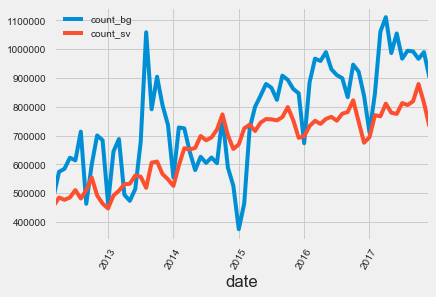

In [5]:
df_all = pd.concat([df['count_bg'], dft['count_sv']], axis = 1, join_axes = [df['count_bg'].index])
df_all = df_all.loc[pd.notnull(df_all['count_sv'])]
df_all = df_all.reset_index()
df_all.plot(x='date', rot=60)
df_all.head()

In [6]:
df_all = df_all.rename(index = str, columns= {'date':'dates'})
df_all = df_all.set_index('dates')
df_all.head()

,count_bg,count_sv
dates,,
2012-03-01,487462,455284.0
2012-04-01,574356,484946.0
2012-05-01,584676,477064.0
2012-06-01,623120,485211.0
2012-07-01,613888,510895.0


In [7]:
y = df_all['count_sv']

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [8]:
# IMPORTANT - searching the space of parameters of the model to find the one with lowest AIC (the most "parsimonious" model)
# SARIMAX = Seasonal ARIMA with exogenous regressor

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, exog=df_all['count_bg'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            time_varying_regression=True,
                                            mle_regression=False,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except ValueError:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1816.5179528667395
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1457.3745530416463
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1123.5430388571788
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1497.6429246355308
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1454.8117933334427
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1149.7071694400374
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1092.8117825303525
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1741.6211191860643
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1431.421068945812
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1433.365125271417
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1106.0661184451785
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1478.1568807247968
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1427.939059436905
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1158.792763871785
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1107.7556939152341
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1311.96680424906
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:998.222014133228
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1316.1804041444677


In [9]:
# IMPORTANT - fitting the models. I recall the "time varying regression" was an important one which helped the make better
# results. Although we're not perfectly sure how that works (something to clarify with TS folks)

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

##----------------------------------------------------------------------
# ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:990.6564500905324 burning glass exog
modx = sm.tsa.statespace.SARIMAX(y, exog=df_all['count_bg'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

resultsx = modx.fit()
print(resultsx.summary().tables[1])

##----------------------------------------------------------------------
# ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:972.3548561981652  burning glass exog and time varying
modx2 = sm.tsa.statespace.SARIMAX(y, exog=df_all['count_bg'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                time_varying_regression=True,
                                mle_regression=False,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

resultsx2 = modx2.fit()
print(resultsx2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2352      0.360     -0.653      0.514      -0.942       0.471
ma.L1         -0.3629      0.343     -1.057      0.290      -1.036       0.310
ar.S.L12      -0.5193      0.170     -3.051      0.002      -0.853      -0.186
ma.S.L12       0.1933      0.261      0.742      0.458      -0.318       0.704
sigma2      6.038e+08   1.97e-10   3.06e+18      0.000    6.04e+08    6.04e+08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
count_bg      -0.0461      0.041     -1.115      0.265      -0.127       0.035
ar.L1         -0.2259      0.322     -0.702      0.483      -0.856       0.405
ma.L1         -0.3851      0.290     -1.327      0.184      -0.954       0.184
ar.S.L12      -0.4519      0.220     -2.055      0.0

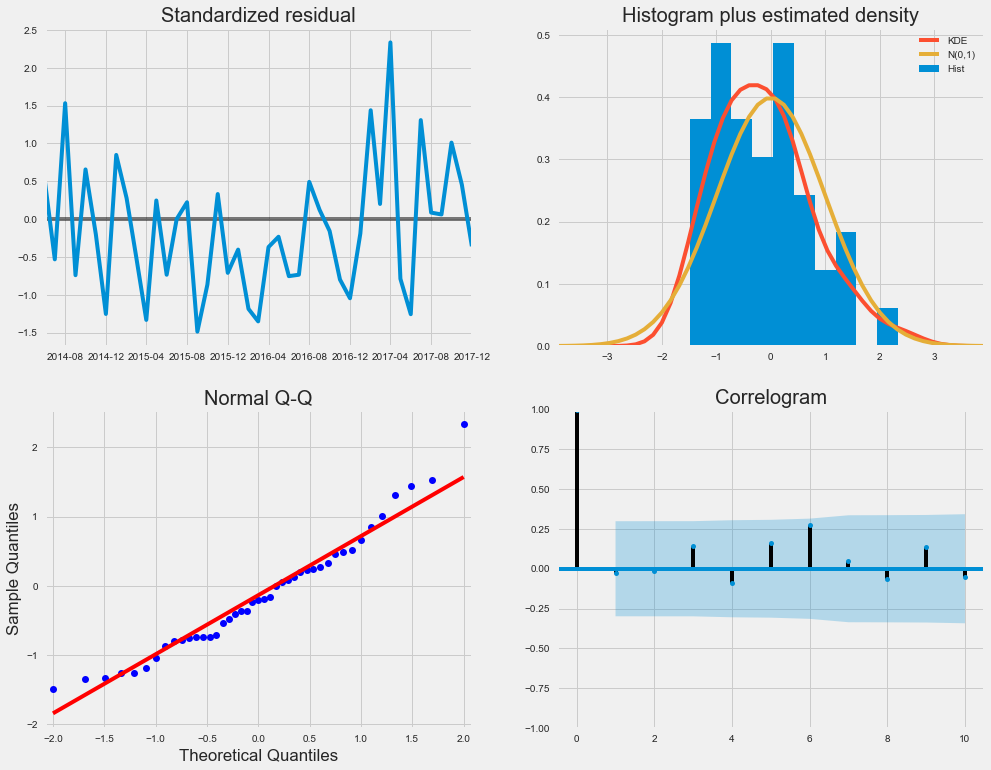

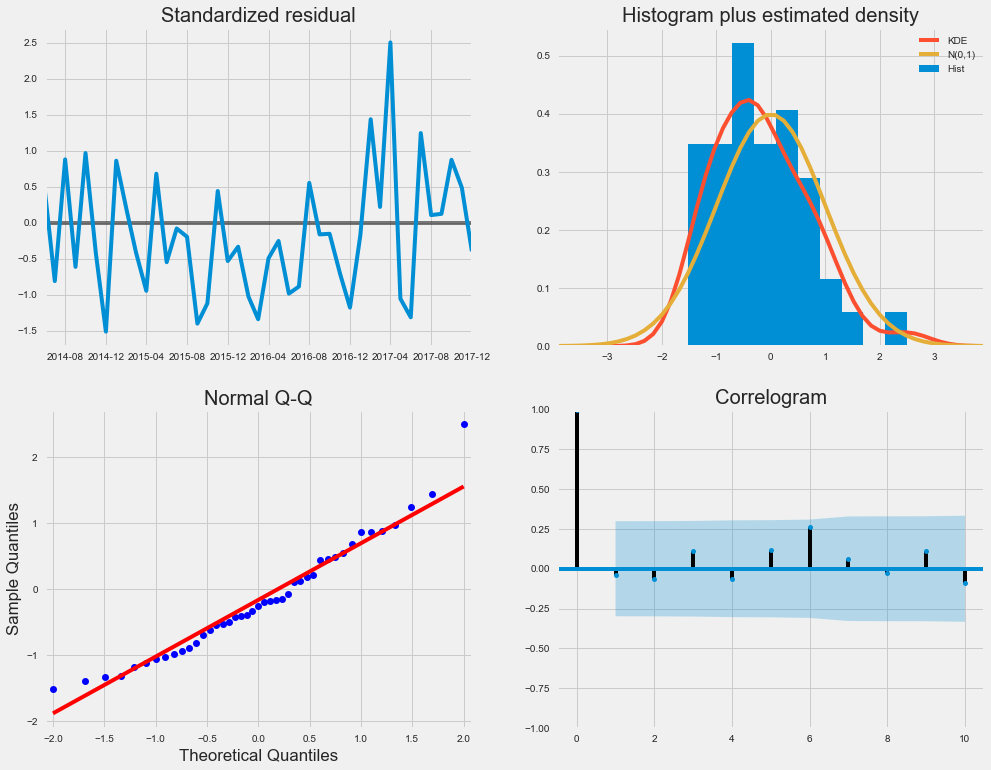

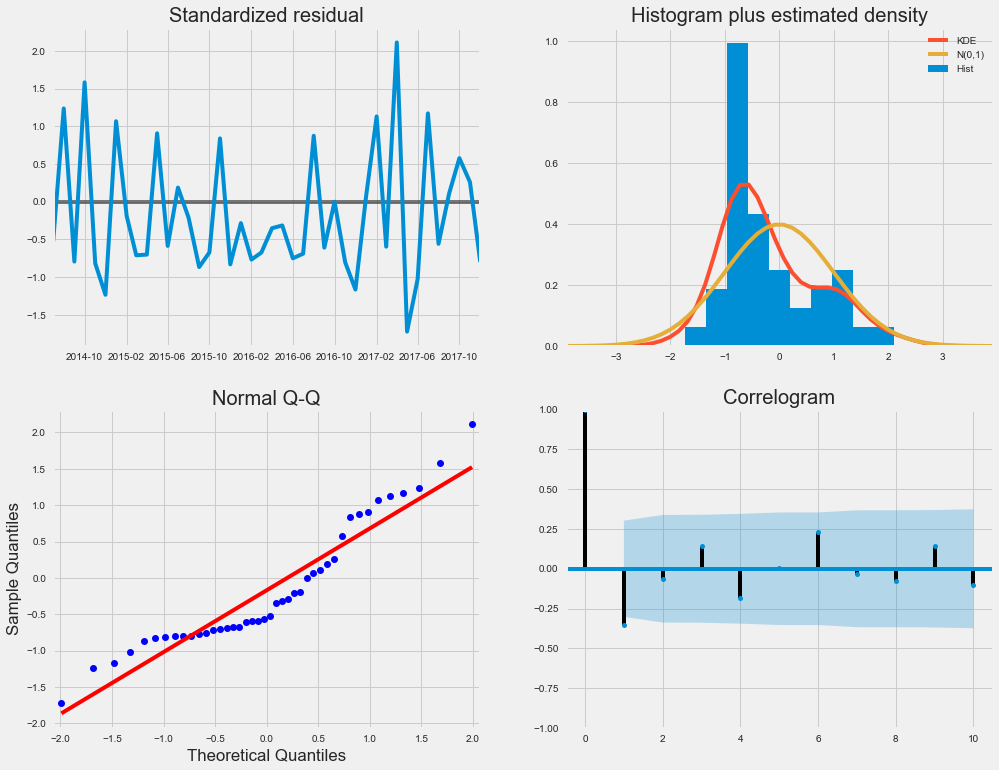

In [10]:
# IMPORTANT - these diagnostics are useful to see if the built model explains the data, or there's still some pattern in the
# residuals, i.e. some unexplained variance and not just noise

results.plot_diagnostics(figsize=(15, 12))
plt.show()

##-----------------------------------------

resultsx.plot_diagnostics(figsize=(15, 12))
plt.show()

##-----------------------------------------

resultsx2.plot_diagnostics(figsize=(15, 12))
plt.show()

In [11]:
pred_dynamicx.conf_int?

Object `pred_dynamicx.conf_int` not found.


In [12]:
# IMPORTANT - getting the predictions

pred_dynamic = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

##-BG exogenous-------------------------------------------

pred_dynamicx = resultsx.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=True, exog=df_all['count_bg'], full_results=True)
pred_dynamic_cix = pred_dynamicx.conf_int()

##-BG exogenous with time varying-------------------------

pred_dynamicx2 = resultsx2.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=True, exog=df_all['count_bg'], full_results=True)
pred_dynamic_cix2 = pred_dynamicx2.conf_int()

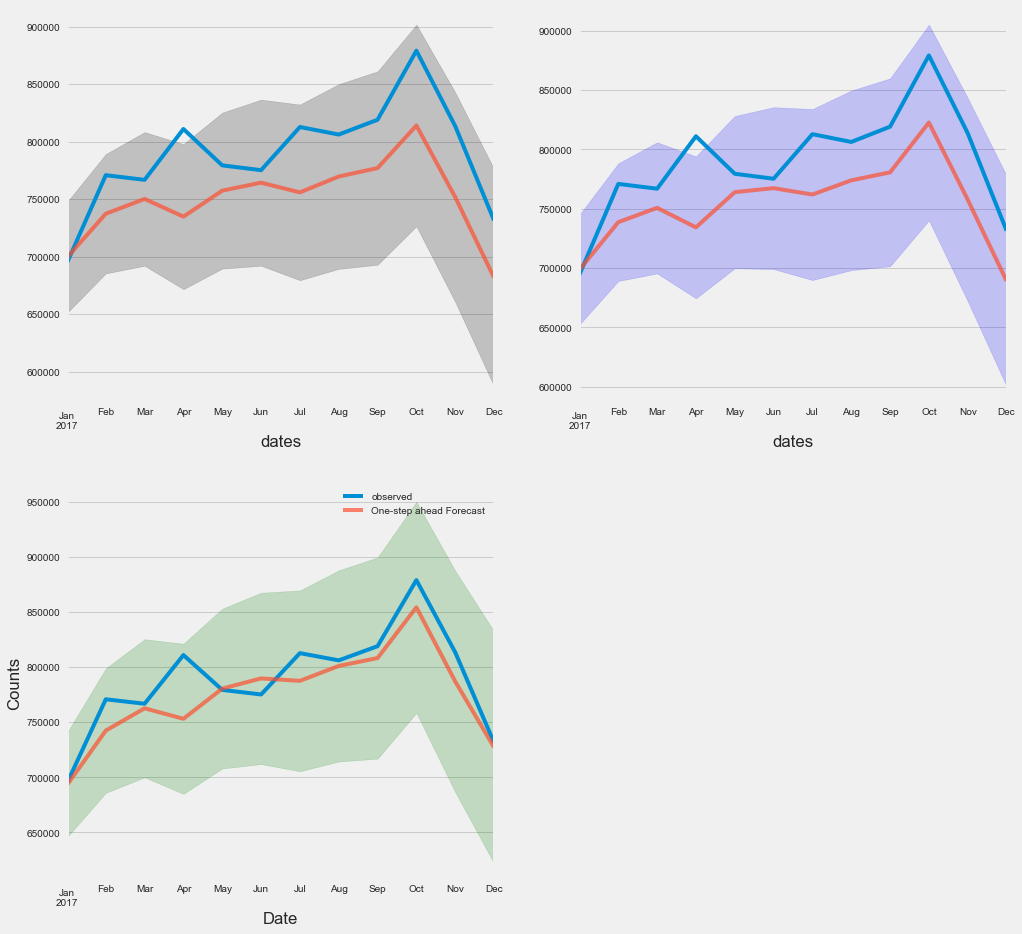

In [13]:
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
ax = y['2017':].plot(label='observed')
pred_dynamic.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

##-BG exogenous-------------------------------------------

plt.subplot(2,2,2)
ax = y['2017':].plot(label='observed')
pred_dynamicx.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_dynamic_cix.index,
                pred_dynamic_cix.iloc[:, 0],
                pred_dynamic_cix.iloc[:, 1], color='b', alpha=.2)

##-BG exogenous with time varying-------------------------

plt.subplot(2,2,3)
ax = y['2017':].plot(label='observed')
pred_dynamicx2.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_dynamic_cix2.index,
                pred_dynamic_cix2.iloc[:, 0],
                pred_dynamic_cix2.iloc[:, 1], color='green', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Counts')
plt.legend()

plt.show()

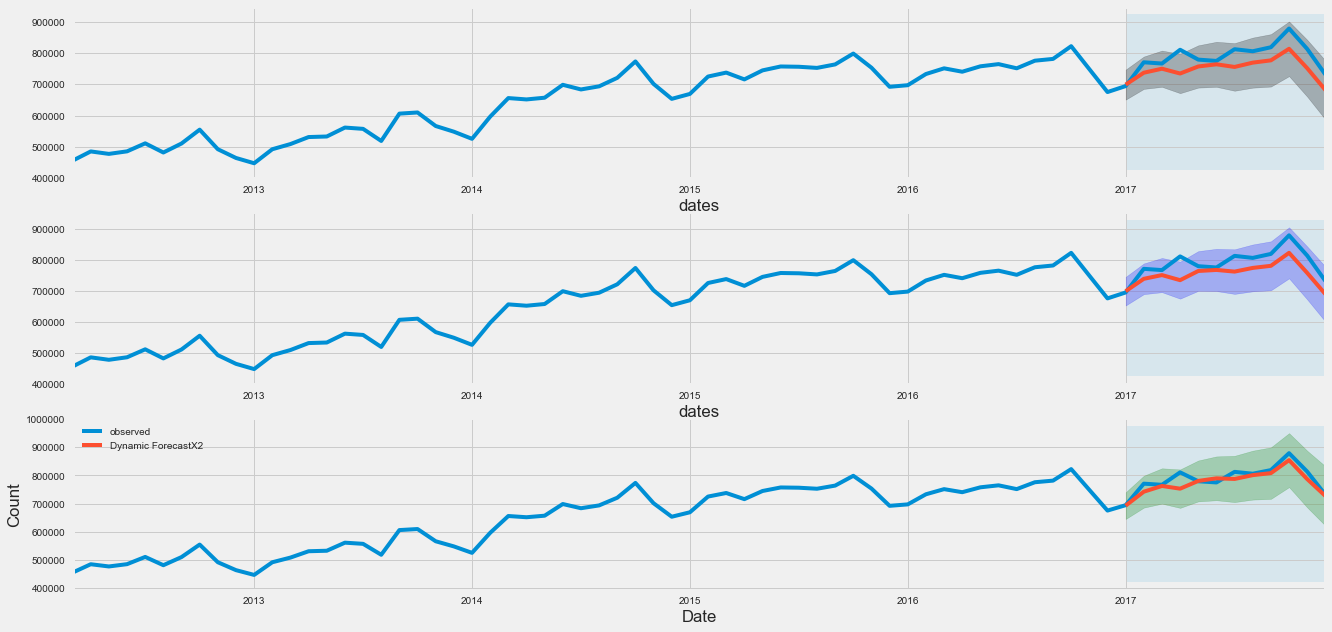

In [14]:
plt.figure(figsize=(15, 15))
plt.subplot(3,1,1)
ax = y['2012':].plot(label='observed', figsize=(20, 10))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

##-BG exogenous--------------------------------------------

# plt.figure(figsize=(15, 5))
plt.subplot(3,1,2)
ax = y['2012':].plot(label='observed', figsize=(20, 10))
pred_dynamicx.predicted_mean.plot(label='Dynamic ForecastX', ax=ax)

ax.fill_between(pred_dynamic_cix.index,
                pred_dynamic_cix.iloc[:, 0],
                pred_dynamic_cix.iloc[:, 1], color='b', alpha=.25)


ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

##-BG exogenous with time varying-------------------------

# plt.figure(figsize=(15, 5))
plt.subplot(3,1,3)
ax = y['2012':].plot(label='observed', figsize=(20, 10))
pred_dynamicx2.predicted_mean.plot(label='Dynamic ForecastX2', ax=ax)

ax.fill_between(pred_dynamic_cix2.index,
                pred_dynamic_cix2.iloc[:, 0],
                pred_dynamic_cix2.iloc[:, 1], color='g', alpha=.25)


ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)


ax.set_xlabel('Date')
ax.set_ylabel('Count')
plt.legend()
plt.show()

In [15]:
z= df_all['count_bg']
# z['2016':]

 link for additional matplotlib customization
 https://stackoverflow.com/questions/43265731/how-to-add-black-border-to-matplotlib-2-0-ax-object-in-python-3

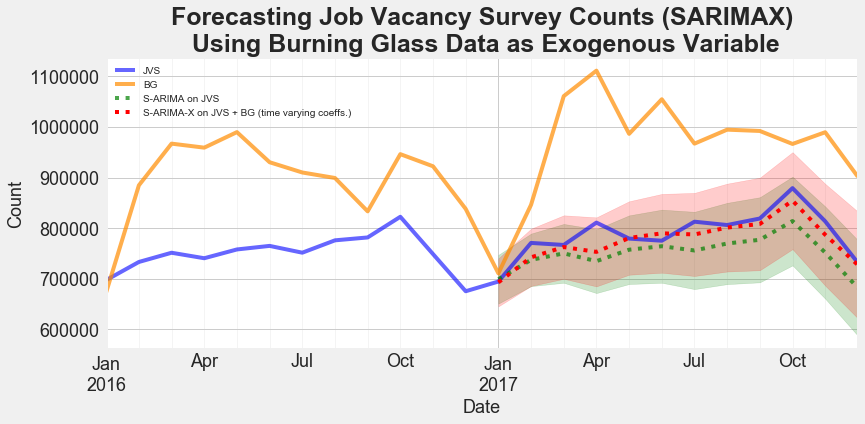

In [16]:
ax = y['2016':].plot(label='JVS', figsize=(12, 5), color='Blue', alpha=.6)
z['2016':].plot(label='BG', color='DarkOrange', style = '-', alpha=.7) 


pred_dynamic.predicted_mean.plot(label='S-ARIMA on JVS', ax=ax, color='Green', style = ':', alpha=.7)
ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='Green', alpha=.2)


# ##-BG exogenous-------------------------------------------
# pred_dynamicx.predicted_mean.plot(label='S-ARIMA-X on JVS + BG', ax=ax, color='Red', style = ':', alpha=0.35)
# # ax.fill_between(pred_dynamic_cix.index,
# #                 pred_dynamic_cix.iloc[:, 0],
# #                 pred_dynamic_cix.iloc[:, 1], color='LightBlue', alpha=.7)


##-BG exogenous with time varying-------------------------
pred_dynamicx2.predicted_mean.plot(label='S-ARIMA-X on JVS + BG (time varying coeffs.)', ax=ax, color='Red', style = ':')
ax.fill_between(pred_dynamic_cix2.index,
                pred_dynamic_cix2.iloc[:, 0],
                pred_dynamic_cix2.iloc[:, 1], color='Red', alpha=.2)




plt.grid(b=True, which='major', color='0.8', alpha= 1, linestyle='-')
plt.grid(b=True, which='minor', color='0.8', alpha= 0.2, linestyle='-')
ax.patch.set_facecolor('white')

ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)
plt.title('Forecasting Job Vacancy Survey Counts (SARIMAX)\n Using Burning Glass Data as Exogenous Variable', 
          fontsize=25, fontweight=600)
plt.legend()
plt.show()

In [17]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error
rmse = ((y_forecasted - y_truth) ** 2).mean()**0.5
print('Root Mean Squared Error  {}   base model'.format(round(rmse, 2)))


##-BG exogenous-------------------------------------------
# Extract the predicted and true values of our time series
y_forecastedx = pred_dynamicx.predicted_mean

# Compute the mean square error
xrmse = ((y_forecastedx - y_truth) ** 2).mean()**0.5
print('Root Mean Squared Error  {}   with exogenous variable'.format(round(xrmse, 2)))


##-BG exogenous with time varying-------------------------
# Extract the predicted and true values of our time series
y_forecastedx2 = pred_dynamicx2.predicted_mean

# Compute the mean square error
x2rmse = ((y_forecastedx2 - y_truth) ** 2).mean()**0.5
print('Root Mean Squared Error  {}   model with exogenous variable and time varying'.format(round(x2rmse, 2)))
print('Errors reduced by: {}% (exogenous variable)'.format(((xrmse-rmse)/rmse)*100))
print('Errors reduced by: {}% (exogenous variable and time varying)'.format(((x2rmse-rmse)/rmse)*100))

Root Mean Squared Error  45335.64   base model
Root Mean Squared Error  41574.7   with exogenous variable
Root Mean Squared Error  23273.61   model with exogenous variable and time varying
Errors reduced by: -8.2957657406488% (exogenous variable)
Errors reduced by: -48.663772491612995% (exogenous variable and time varying)


In [18]:
# Get forecast 70 steps ahead in future
pred_uc = results.get_forecast(steps=70)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()


##-BG exogenous-------------------------------------------
# Get forecast 15 steps ahead in future
a = df_all['count_bg']
a= np.reshape(a, (a.shape[0], 1)) 
a.shape
pred_ucx = resultsx.get_forecast(steps=70, exog=a)

# Get confidence intervals of forecasts
pred_cix = pred_ucx.conf_int()


##-BG exogenous with time varying--------------------------
# Get forecast 15 steps ahead in future
pred_ucx2 = resultsx2.get_forecast(steps=70, exog=a)

# Get confidence intervals of forecasts
pred_cix2 = pred_ucx2.conf_int()

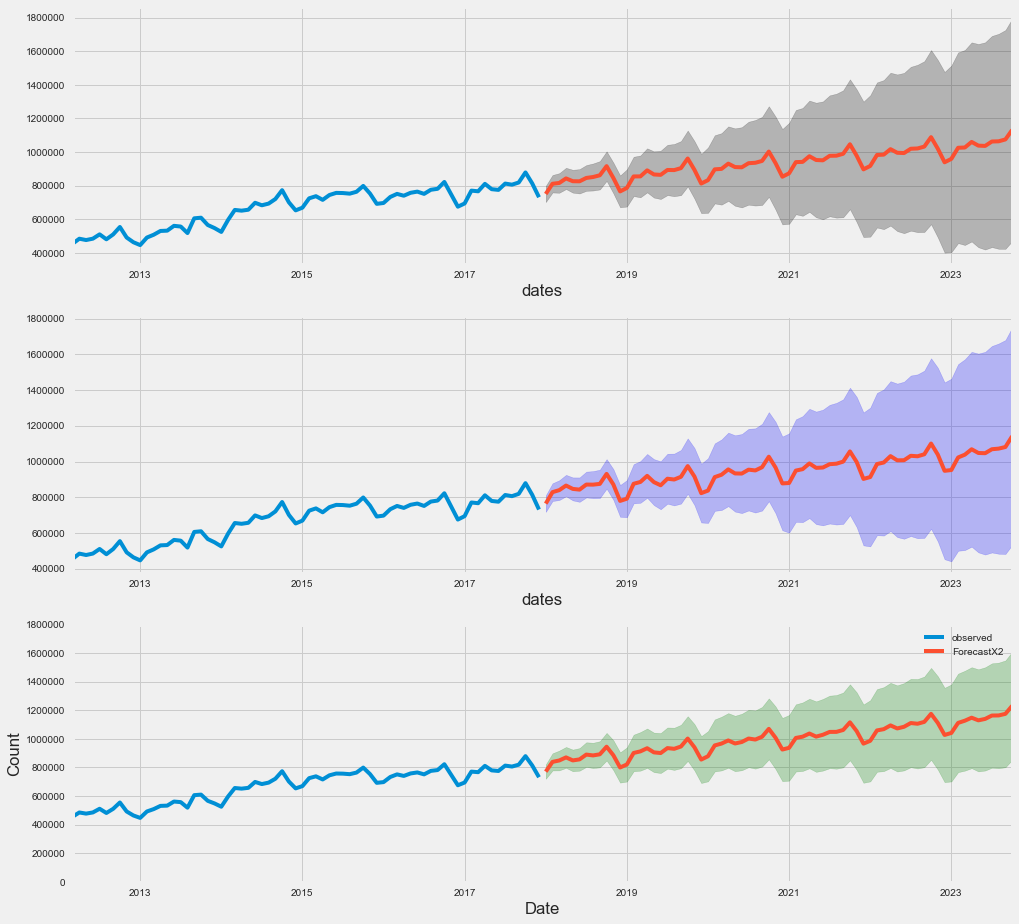

In [19]:
plt.figure(figsize=(15, 15))
plt.subplot(3,1,1)
ax = y.plot(label='observed')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)


##-BG exogenous--------------------------------------------

plt.subplot(3,1,2)
ax = y.plot(label='observed')
pred_ucx.predicted_mean.plot(ax=ax, label='ForecastX')
ax.fill_between(pred_cix.index,
                pred_cix.iloc[:, 0],
                pred_cix.iloc[:, 1], color='b', alpha=.25)

##-BG exogenous with time varying-------------------------

plt.subplot(3,1,3)
ax = y.plot(label='observed')
pred_ucx2.predicted_mean.plot(ax=ax, label='ForecastX2')
ax.fill_between(pred_cix2.index,
                pred_cix2.iloc[:, 0],
                pred_cix2.iloc[:, 1], color='g', alpha=.25)


ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_ylim(0, 1800000)
plt.legend()
plt.show()